### File for generating figures for DNN filter paper

In [3]:
#setup - rememeber to switch to tensorflow 2.3 kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import trimesh
import time
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 2*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

print(tf.__version__)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


In [4]:
#load mesh of object
surf_fn = "/home/derm/ASAR/v3/perspective_shift/figures/wall_scaled.stl"
M = trimesh.load(surf_fn)
#get ground truth translation
gt = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/figures/gt.txt")
print(gt)
#load point clouds of surface generated in Matlab
pts1_fn = "/home/derm/ASAR/v3/perspective_shift/figures/s1.txt"
pts1 = np.loadtxt(pts1_fn)
pts2_fn = "/home/derm/ASAR/v3/perspective_shift/figures/s2.txt"
pts2 = np.loadtxt(pts2_fn)
# pts = pts - gt #+ np.array([20,5,1.72])

#temp for making wall fig
pts2 = pts2[pts2[:,1] < -39]
pts1 = pts1[pts1[:,1] < -40]
print(np.shape(pts2))

[-40.  -40.   -5.2]
(1595, 3)


In [5]:
#plot with Vedo
plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []
disp.append(Points(pts1, c = 'red', r = 5, alpha = 1))
disp.append(Points(pts2 - np.array([1,1,0]), c = 'blue', r = 5, alpha = 1))
w1 = Mesh(M).c("gray").alpha(1)
w1.pos(gt[0], gt[1], gt[2])
print(gt[2])
disp.append(w1)

# L = Light(pos = (30,30,30), focalPoint = (0,0,0), angle = 180, c = (1,1,1), intensity = 1, removeOthers = False)
# disp.append(L)

plt1.show(disp, "Fig 2.1")
ViewInteractiveWidget(plt1.window)

-5.2


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Plot Points + distributions

In [6]:
#Run ICET
import os
import sys
import inspect
# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parentdir = os.path.dirname(os.path.dirname(currentdir))
# sys.path.insert(0, parentdir)

# sys.path.insert(0,"/home/derm/ASAR/v3")

# print(currentdir)
# print(parentdir)
# print(sys.path)

from ICET_spherical import ICET

D = True
# D = False
it1 = ICET(cloud1 = pts1, cloud2 = pts2,  fid = 70, draw = D, 
            niter = 5, group= 2, RM = False, DNN_filter = False)

#add mesh to ICET visualization
w2 = Mesh(M).c("gray").alpha(0.25)
w2.pos(gt[0], gt[1], gt[2])
it1.disp.append(w2)
it1.plt.show(it1.disp, "Figure 2", resetcam = False)

ViewInteractiveWidget(it1.plt.window)

ModuleNotFoundError: No module named 'ICET_spherical'

# Missed Detection/ False Alarm plots

In [7]:
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Times"],
    "font.size": 12})

<IPython.core.display.Javascript object>


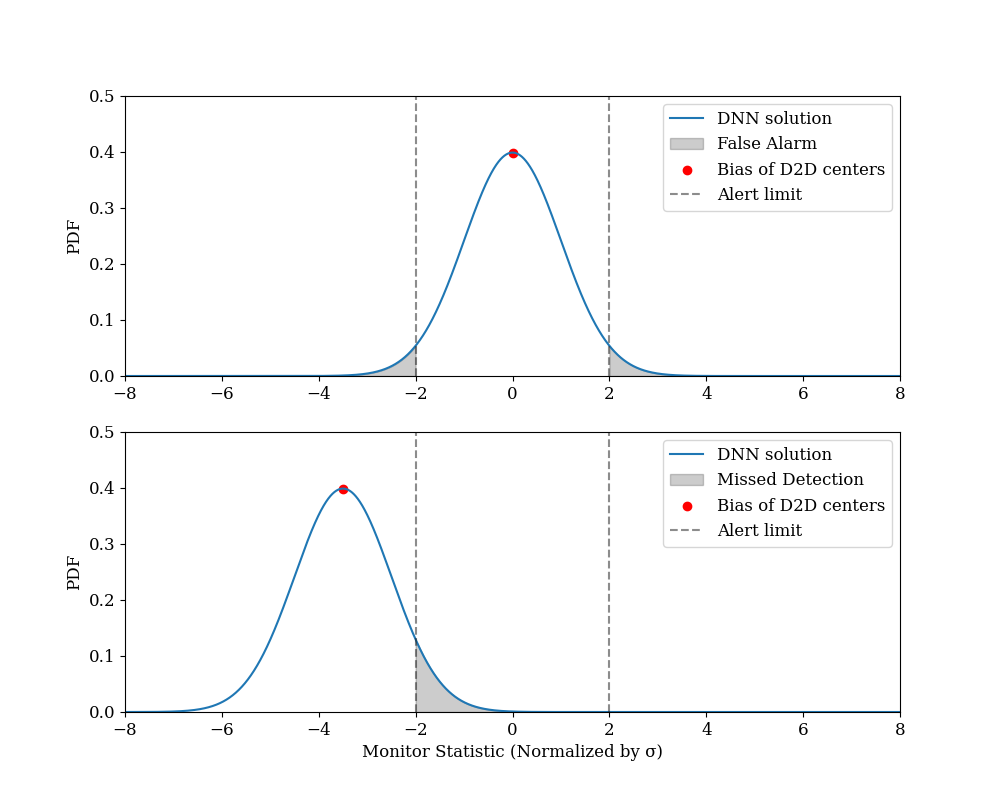

0.3989422804014327


In [8]:
#2 Sided Plots
fig, ax = plt.subplots(2,1)

thresh = 2
width = 8
xlim = 8
bias = -3.5

#Top Plot: 
x_data = np.arange(-width, width, 0.001)
y_data = stats.norm.pdf(x_data, 0, 1)
ax[0].plot(x_data, y_data, label = "DNN solution")
ax[0].set_ylim(0,0.5)
ax[0].set_xlim(-xlim,xlim)
ax[0].set_ylabel("PDF")
ax[0].fill_between(x_data[x_data > thresh],
                   stats.norm.pdf(x_data[x_data > thresh], 0, 1), 
                   color = [0,0,0], alpha = 0.2, label = 'False Alarm')
ax[0].fill_between(x_data[x_data < -thresh],
                   stats.norm.pdf(x_data[x_data < -thresh], 0, 1), 
                   color = [0,0,0], alpha = 0.2)
ax[0].scatter(0, np.max(y_data), color = (1,0,0), label = 'Bias of D2D centers')
ax[0].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert limit")
ax[0].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[0].legend(loc = 'upper right')

#Bottom Plot
ax[1].set_xlabel("Monitor Statistic (Normalized by σ)")
ax[1].set_ylabel("PDF")
x_data = np.arange(-width, width, 0.001)
y_data = stats.norm.pdf(x_data-bias, 0, 1)
ax[1].plot(x_data, y_data, label = "DNN solution")
ax[1].set_ylim(0,0.5)
ax[1].set_xlim(-xlim,xlim)
ax[1].set_ylabel("PDF")
if bias > 0:
    ax[1].fill_between(x_data[x_data < thresh],
                       stats.norm.pdf(x_data[x_data < thresh] - bias, 0, 1), 
                       color = [0,0,0], alpha = 0.2, label = 'False Alarm')
if bias < 0:
    ax[1].fill_between(x_data[x_data > -thresh],
                       stats.norm.pdf(x_data[x_data > -thresh] - bias, 0, 1), 
                       color = [0,0,0], alpha = 0.2, label = 'Missed Detection')
ax[1].scatter(bias, np.max(y_data), color = (1,0,0), label = 'Bias of D2D centers')
ax[1].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert limit")
ax[1].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[1].legend(loc = 'upper right')

print(np.max(y_data))

<IPython.core.display.Javascript object>


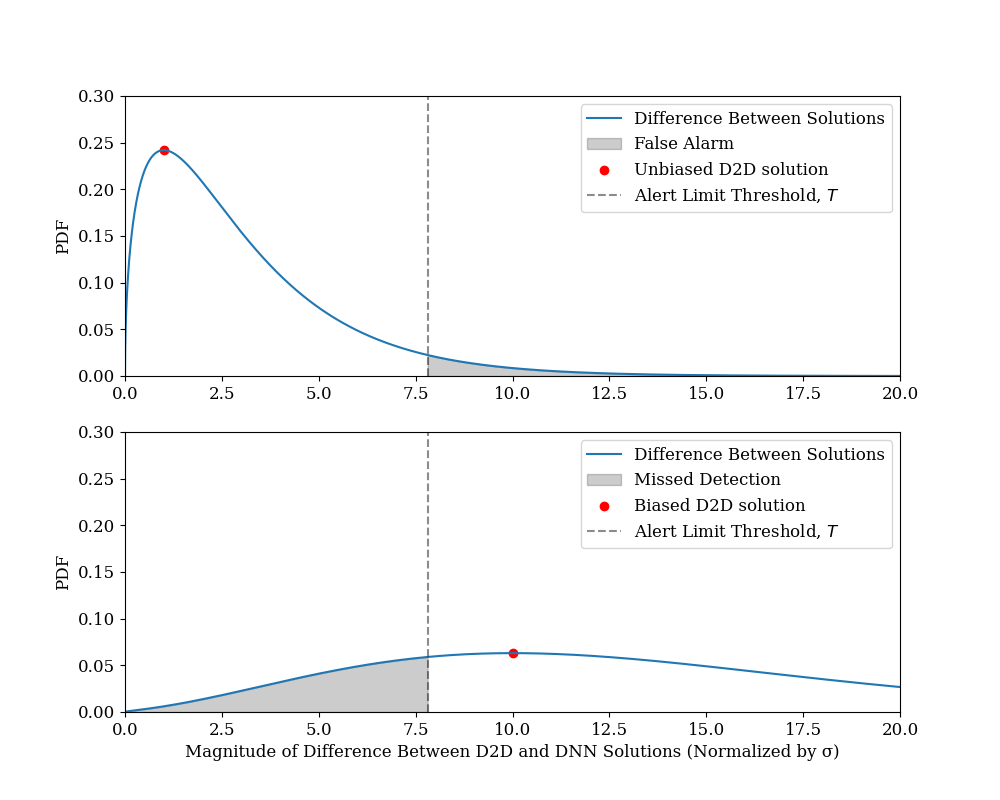

In [9]:
#1 Sided Plots
fig, ax = plt.subplots(2,1)

thresh = 7.81 #associated with 95% confidence bound for 3DOF chi-square with sigma=1
# thresh = 6.25 #90%
df = 3 #degrees of freedom
nc = 10 #Noncenterality Parameter gamma
width = 20
xlim = 20
stretch = 1 #larger number means more squish
thresh = thresh/stretch

#Top Plot:
x_data = np.arange(0, width, 0.001)
y_data = stats.chi2.pdf(x_data*stretch, df=3)

ax[0].plot(x_data, y_data, label = "Difference Between Solutions")
ax[0].set_ylim(0,0.3)
ax[0].set_xlim(0,xlim)
ax[0].set_ylabel("PDF")
ax[0].fill_between(x_data[x_data > thresh],
                   stats.chi2.pdf(stretch*x_data[x_data > thresh], df=3),
                   color = [0,0,0], alpha = 0.2, label = 'False Alarm')
# ax[0].scatter(x_data[1000], y_data[1000], color = (1,0,0), label = 'Bias of D2D solution')
ax[0].scatter(x_data[y_data == np.max(y_data)], np.max(y_data), color = (1,0,0), label = 'Unbiased D2D solution')
ax[0].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert Limit Threshold, $T$")
ax[0].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[0].legend(loc = 'upper right')

#Bottom Plot - TODO- stretch this to start at 0
ax[1].set_xlabel("Magnitude of Difference Between D2D and DNN Solutions (Normalized by σ)")
ax[1].set_ylabel("PDF")
ax[1].set_ylim(0,0.3)
ax[1].set_xlim(0,xlim)
ax[1].set_ylabel("PDF")

#old (wrong) - using shifted chi-squre distribution---------------------------------------
# bias = 3
# ax[1].plot(x_data+bias, y_data, label = "Difference Between Solutions")
# ax[1].fill_between(x_data[x_data < thresh-bias] + bias,
#                        stats.chi2.pdf(stretch*x_data[x_data < thresh-bias], df=3),
#                        color = [0,0,0], alpha = 0.2, label = 'Missed Detection')
#new- Non-central Chi-Square distribution-------------------------------------------------
y_data_biased = stats.ncx2(df, nc).pdf(x_data*stretch)
ax[1].plot(x_data, y_data_biased, label = "Difference Between Solutions")
ax[1].fill_between(x_data[x_data < thresh],
                   y_data_biased[x_data < thresh],
                   color = [0,0,0], alpha = 0.2, label = 'Missed Detection')
#-----------------------------------------------------------------------------------------

ax[1].scatter(x_data[y_data_biased == np.max(y_data_biased)], np.max(y_data_biased), color = (1,0,0), label = 'Biased D2D solution')
ax[1].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert Limit Threshold, $T$")
ax[1].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[1].legend(loc = 'upper right')


## Figure 1: draw multiple objects in same scene

In [10]:
# bgc = (0,0,0)
bgc = (1,1,1) #background color
mc  = (0.5,0.5,0.5) #'white' #
plt2 = Plotter(N = 1, axes = 4, bg = bgc, interactive = True)
disp2 = []
alph = 1#alpha for points
rad = 5

#load point clouds
c1 = np.loadtxt('fig1_s1.txt') 
c2 = np.loadtxt('fig1_s2.txt')
gt = np.loadtxt('fig1_gt.txt')
print(gt)
ground = -2.55 #define ground height
c1_ground = c1[c1[:,2] < ground]
c2_ground = c2[c2[:,2] < ground]
c1 = c1[c1[:,2] > ground] #remove ground plane
c2 = c2[c2[:,2] > ground]

surf_fn = "Assembly1_scaled.stl"
M = trimesh.load(surf_fn)
w1 = Mesh(M).c(mc).alpha(0.2)
w1.pos(0, 0, -1.2)
w1.crop(bounds = [-10,10,-10,10,-1.45,5])
disp2.append(w1)

vox_fn = "voxel.stl"
v1 = Mesh(trimesh.load(vox_fn)).c((0,0,0)) #draw voxel around head of dummy
v1.pos(-5.5,7.5,0)
# disp2.append(v1)

v2 = Mesh(trimesh.load(vox_fn)).c((0,0,0))
v2.pos(2.5,7,-1)
# disp2.append(v2)


#add light 
# L = Light(pos = (0,-10,30), focalPoint = (0,0,0), angle = 180, c = (1,1,1), intensity = 1, removeOthers = False)
# disp2.append(L)

disp2.append(Points(c1, c = 'red', r = rad, alpha = alph))
# disp2.append(Points(c2 - gt/10, c = 'blue', r = rad, alpha = alph))
# disp2.append(Points(c1_ground, c = 'red', r = rad, alpha = alph/4))
# disp2.append(Points(c2_ground - gt/10, c = 'blue', r = rad, alpha = alph/4))

plt2.show(disp2, "Figure 1")
ViewInteractiveWidget(plt2.window)

[100.   0.   0.]


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Experiment 2: Correcting ICET Estimates with DNN

<IPython.core.display.Javascript object>


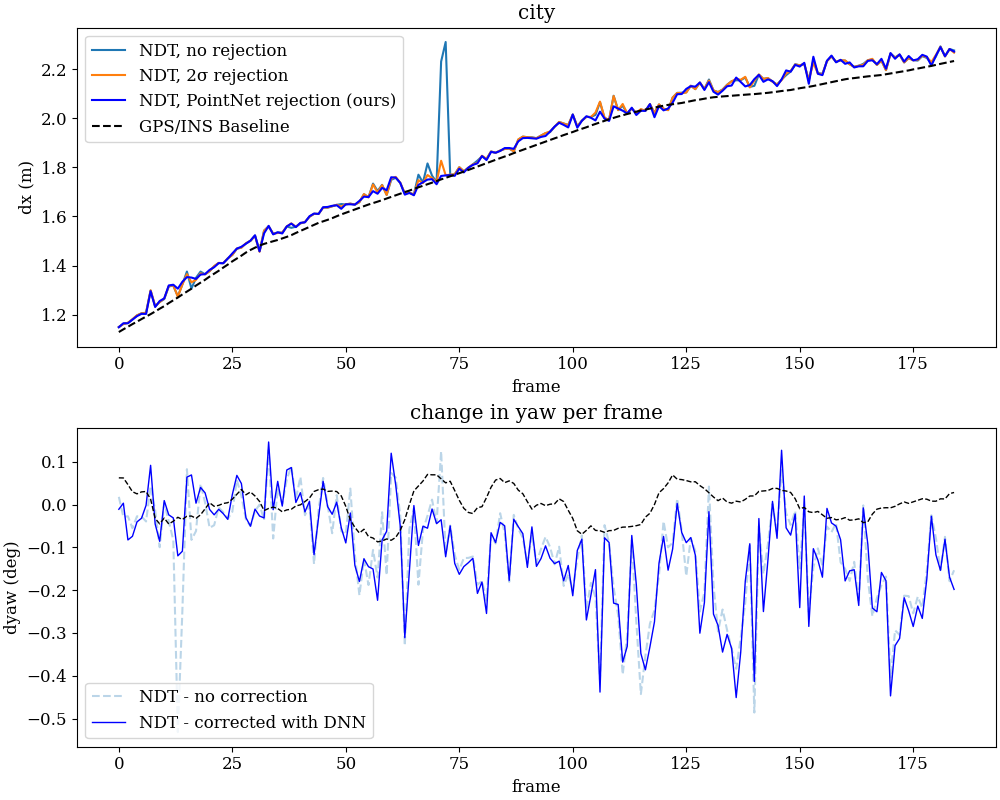

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook
# font = {'fontname':'Times New Roman'}

# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/ICET_estimates_v8.txt") #best old DNN (from spring...)

# # #0005 ~~~~~~~~~~~
# # ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# # # ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_CompactNet_2cmThresh.txt") #CompactNet.kmod 

# # # OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/OXTS_baseline_v17.txt") #using vel
# # OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_OXTS_baseline_alt.txt")#GNSS conversion

# # BC = np.loadtxt("/home/derm/ASAR/v3/Before_correction_v18.txt") #actually before correction
# # # BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# # # ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/ICET_pred_stds_v13.txt") #old (for debug)
# # ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_pred_stds_2cmThresh.txt")

# # ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# # OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_OXTS_baseline_gps.txt")
# # ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_pred_stds_5cmThresh.txt")
# # BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_noDNN.txt")

# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_CompactNet_3cmThresh.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_OXTS_baseline_gps.txt")
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_pred_stds_3cmThresh.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_noDNN.txt")
# worst = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_noFilter.txt")
# # BC = worst #debug
# # #~~~~~~~~~~~~~~~~

#0095~~~~~~~~~~~~
# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0095_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0095_OXTS_baseline_gps.txt")
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0095_pred_stds_5cmThresh.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0095_noDNN.txt")
# # OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0095_OXTS_baseline_alt.txt")
#~~~~~~~~~~~~~~~~

#0027 ~~~~~~~~~~~~ straight road, heavily wooded
#best so far...
# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# # OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_OXTS_baseline_gps.txt")
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_OXTS_baseline_alt.txt")
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_pred_stds.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_noDNN.txt")
# worst = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_noFilter.txt")

#testing here
ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027v5_CompactNet_3cmThresh.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_OXTS_baseline_alt.txt")
OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_OXTS_baseline_gps.txt")
ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027v5_pred_stds_3cmThresh.txt")
BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027v5_noDNN.txt")
worst = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_noFilterv5.txt")

#outlier rejection (FOR DEBUG ONLY!)
# rejectThresh = .75
# diff_cheat_DNN = abs(ICET_estimates[:,0] - gt_fwd)
# bad_idx_DNN = np.where(diff_cheat_DNN > rejectThresh)
# ICET_estimates[bad_idx_DNN,0] = gt_fwd[bad_idx_DNN]
# diff_cheat_BC = abs(BC[:,0] - gt_fwd)
# bad_idx_BC = np.where(diff_cheat_BC > rejectThresh)
# BC[bad_idx_BC,0] = gt_fwd[bad_idx_BC]
# diff_cheat_worst = abs(worst[:,0] - gt_fwd)
# bad_idx_worst = np.where(diff_cheat_worst > rejectThresh)
# worst[bad_idx_worst,0] = gt_fwd[bad_idx_worst]
# BC = worst #debug
#~~~~~~~~~~~~~~~~

# #0028~~~~~~~~~~~~ curved road, heavily wooded
# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0028_CompactNet_3cmThresh.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0028_OXTS_baseline_gps.txt")
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0028_pred_stds.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0028_noDNN.txt")
# # worst = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_noFilterv5.txt")

# # ICET_estimates[:,0] = ICET_estimates[:,0]*0.1/dt
# # BC[:,0] = BC[:,0]*0.1/dt
# #~~~~~~~~~~~~~~~~


# #0117 ~~~~~~~~~~~~ straight campus road, lots of trees (decent improvement with DNN)
# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0117_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0117_OXTS_baseline_gps.txt")
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0117_pred_stds_5cmThresh.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0117_noDNN.txt")
# #~~~~~~~~~~~~~~~~

# #0070 ~~~~~~~~~~~~ straight highway with large trees and embankment. No foliage, no large constraining surfaces
# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0070_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0070_OXTS_baseline_gps.txt")
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0070_pred_stds_5cmThresh.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0070_noDNN.txt")
# #~~~~~~~~~~~~~~~~

# #0071 ~~~~~~~~~~~~ crowded shopping area (timing errors!)
# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0071_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0071_OXTS_baseline_gps.txt")
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0071_pred_stds_5cmThresh.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0071_noDNN.txt")
# offset = 7
# ICET_estimates = ICET_estimates[:-offset] #fix offsest errors in ground truth
# BC = BC[:-offset]
# ICET_pred_stds = ICET_pred_stds[:-offset]
# OXTS_baseline = OXTS_baseline[offset:]
# #~~~~~~~~~~~~~~~~

OXTS_baseline = (OXTS_baseline/0.1*0.1037 + OXTS_baseline)/2 #correct for timing differences
# OXTS_baseline = OXTS_baseline/0.1*0.1037  #correct for timing differences


# ICET_estimates[:,0] = ICET_estimates[:,0]/tvec*0.1

#fix sign errors
ICET_estimates[:,1] = -ICET_estimates[:,1]
ICET_estimates[:,3:] = -ICET_estimates[:,3:]
BC[:,1] = -BC[:,1]
BC[:,3:] = -BC[:,3:]

style1 = 'b-'
style2 = 'k--'
style3 = '--'

gt_fwd = np.sqrt(OXTS_baseline[:,0]**2 + OXTS_baseline[:,1]**2)
# gt_fwd = OXTS_baseline[:,0]

fig, ax = plt.subplots(2,1, constrained_layout = True)
# ax[0].plot(worst[:,0], label = 'NDT, no rejection')
ax[0].plot(worst[:,0], label = 'NDT, no rejection')
ax[0].plot(BC[:,0], label = 'NDT, 2σ rejection')
ax[0].plot(ICET_estimates[:,0], style1, label = 'NDT, PointNet rejection (ours)')
ax[0].plot(gt_fwd, style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.sqrt(OXTS_baseline[:,0]**2 + OXTS_baseline[:,1]**2), style2, label = 'GPS/INS Baseline')
ax[0].set_title("city")
ax[0].set_ylabel("dx (m)")
ax[0].legend(loc = 'best')
ax[0].set_xlabel("frame")

ax[1].plot(np.rad2deg(BC[:,5]), style3, alpha = 0.3, label = "NDT - no correction")
ax[1].plot(np.rad2deg(ICET_estimates[:,5]), style1, lw = 1, label = "NDT - corrected with DNN")
ax[1].plot(np.rad2deg(OXTS_baseline[:,5]), style2, lw = 1)
ax[1].set_title("change in yaw per frame")
ax[1].set_ylabel("dyaw (deg)")
ax[1].set_xlabel("frame")
ax[1].legend(loc = 'best')


# fig.tight_layout(h_pad = 0.1)
plt.show()

In [12]:
#get velocity error from OXTS
import pykitti
basedir = '/media/derm/06EF-127D1/KITTI'
date = '2011_09_26'
# drive = '0027' #wooded highway - doing really well here!??!
drive = '0005' #city
dataset = pykitti.raw(basedir, date, drive)

idx = 0
dat = dataset.oxts[idx][0]
print(dat)
# print(dat["vel_accuracy"])

OxtsPacket(lat=49.011212804408, lon=8.4228850417969, alt=112.83492279053, roll=0.022447, pitch=1e-05, yaw=-1.2219096732051, vn=-3.3256321640686, ve=1.1384311814592, vf=3.5147680214713, vl=0.037625160413037, vu=-0.03878884255623, ax=-0.29437452763793, ay=0.037166856911681, az=9.9957015129717, af=-0.30581030960531, al=-0.19635662515203, au=9.9942128010936, wx=-0.017332142869546, wy=0.024792163815438, wz=0.14511808479348, wf=-0.017498934149631, wl=0.021393359392165, wu=0.14563031426063, pos_accuracy=0.49229361157748, vel_accuracy=0.068883960397178, navstat=4, numsats=10, posmode=4, velmode=4, orimode=0)


<IPython.core.display.Javascript object>


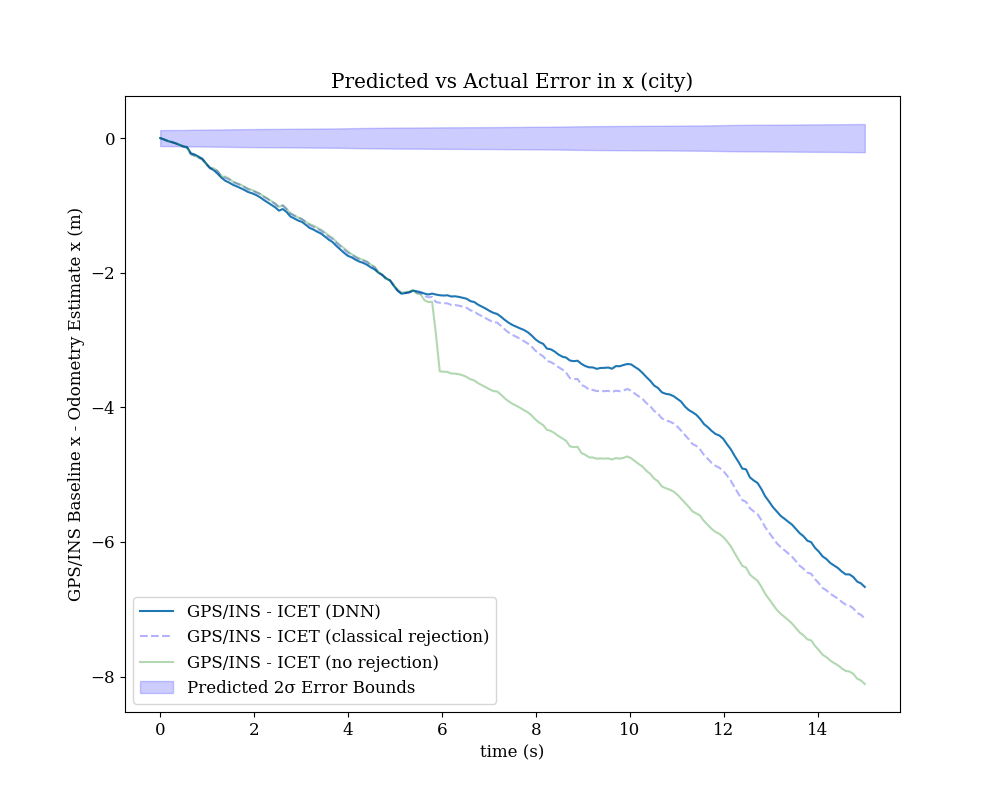

correlation coefficient 
 [[1.         0.20374474]
 [0.20374474 1.        ]]


Text(0, 0.5, 'GPS/INS Baseline x - Odometry Estimate x (m)')

In [13]:
#plot error between ICET and absolute position
fig3, ax3 = plt.subplots(1,1)

#which component to look at
# c = 5 #yaw
c = 0 # x (forward movement)

diffx = OXTS_baseline[:,c] - ICET_estimates[:,c]
diffx_BC = OXTS_baseline[:,c] - BC[:,c]
diffx_worst = OXTS_baseline[:,c] - worst[:,c]


# print(abs(diffx))
print("correlation coefficient \n", np.corrcoef(abs(diffx), ICET_pred_stds[:,0]))

#flip sign when looking at yaw
if c ==5:
    diffx = -diffx 
    diffx_BC = -diffx_BC
    diffx_worst = -diffx_worst
    
cum_err = np.zeros(np.shape(ICET_pred_stds))
cum_diffx = np.zeros(np.shape(diffx))
cum_diffx_BC = np.zeros(np.shape(diffx_BC))
cum_diffx_worst = np.zeros(np.shape(diffx_worst))

for i in range(np.shape(ICET_pred_stds)[0]):
    cum_err[i,:] = np.sum(ICET_pred_stds[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
#     cum_err[i,:] += np.sqrt(2)*np.array([0.08,0.08,0.1,0.0005,0.0005,0.001745])**2
#     cum_err[i,:] += np.sqrt(2)*np.array([0.0,0.0,0.,0.000,0.000,0.00])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 

#     #test
#     cum_err[i,:] = np.sum(ICET_pred_stds[:i,:]**2, axis = 0)
# #     cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
#     cum_err[i,:] = np.sqrt(cum_err[i,:])     
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 
    cum_diffx_BC[j] = np.sum(diffx_BC[:j]) 
    cum_diffx_worst[j] = np.sum(diffx_worst[:j]) 

# # #old (error for each individual timestep)------------------------
# ax3.plot(diffx, label = 'GPS/INS - NDT (with DNN)')
# ax3.plot(diffx_BC, 'b--', label = 'GPS/INS - NDT (no DNN)', alpha = 0.3)
# ax3.fill_between(np.linspace(0,150,np.shape(ICET_pred_stds)[0]), -2*ICET_pred_stds[:,c], 2*ICET_pred_stds[:,c], 
#                  color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
# #-------------------------------------------------------------------

# #new (accumulated differences in error)--------------------------
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx, label = 'GPS/INS - ICET (DNN)')
ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_BC, 'b--', alpha = 0.3, label = 'GPS/INS - ICET (classical rejection)')
ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_worst, 'g', alpha = 0.3, label = 'GPS/INS - ICET (no rejection)')
ax3.fill_between(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), -2*cum_err[:,c], 2*cum_err[:,c], 
                 color = (0,0,1,0.2), label = 'Predicted 2σ Error Bounds')
# # --------------------------------------------------------------------

ax3.legend(loc = 'lower left')
# ax3.legend(loc = 'best')
ax3.set_title("Predicted vs Actual Error in x (city)")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("GPS/INS Baseline x - Odometry Estimate x (m)")
# ax3.set_title("Predicted vs Actual Error in yaw")
# ax3.set_xlabel("time (s)")
# ax3.set_ylabel("GPS/INS Baseline yaw - Odometry Estimate yaw (rad)")
# ax3.set_ylim(-0.032,0.045)
# ax3.set_ylim([-0.07,0.07])

In [14]:
#get RMSE for each method
import sklearn
from sklearn.metrics import mean_squared_error

# print(diffx)
# print(diffx_BC)

RMSE_DNN = np.sqrt(mean_squared_error(diffx, np.zeros(np.shape(diffx))))
print("RMSE_DNN: \n", RMSE_DNN)

RMSE_BC = np.sqrt(mean_squared_error(diffx_BC, np.zeros(np.shape(diffx))))
print("RMSE_BC: \n", RMSE_BC)

rel = (RMSE_BC - RMSE_DNN)/RMSE_BC
# print(rel)

RMSE_DNN: 
 0.04455078386071584
RMSE_BC: 
 0.046322082968576136


In [15]:
print(ICET_pred_stds)

[[0.00290352 0.00287265 0.00241833 0.00029066 0.00032557 0.00043386]
 [0.00359717 0.00292221 0.00268804 0.00032962 0.00032739 0.00049836]
 [0.00512834 0.00753645 0.0029577  0.0003766  0.00035691 0.00057056]
 ...
 [0.00688276 0.0071525  0.00507721 0.00053781 0.00053372 0.00060213]
 [0.00717373 0.007099   0.00431829 0.00047224 0.00054204 0.00060442]
 [0.00865247 0.00797308 0.00534615 0.00051537 0.00056534 0.00055973]]


In [16]:
#DEBUG-- get timestamps of each LIDAR frame - make sure scaling isn't getting messed up...

import pykitti
import datetime

basedir = '/media/derm/06EF-127D1/KITTI'
date = '2011_09_26'
drive = '0028'
num_frames = 100
dataset = pykitti.raw(basedir, date, drive)

# print(dataset.oxts[0])
print(dataset.get_velo(10))

ts = dataset.timestamps
# print(ts)

dt = np.zeros([num_frames])
for i in range(num_frames):
    dt[i] = (dataset.timestamps[i+1] - dataset.timestamps[i]).microseconds/(10e5)
# print(dt)
     

[[75.803  0.164  2.772  0.   ]
 [77.547  0.656  2.831  0.   ]
 [76.977  0.892  2.812  0.   ]
 ...
 [ 3.708 -1.402 -1.732  0.16 ]
 [ 3.732 -1.398 -1.742  0.29 ]
 [ 3.726 -1.389 -1.738  0.   ]]


# Experiment 2 on Synthetic KITTI-CARLA dataset

(500000, 13)
[ -73.59878067 -258.58998854    7.12791812]


<IPython.core.display.Javascript object>


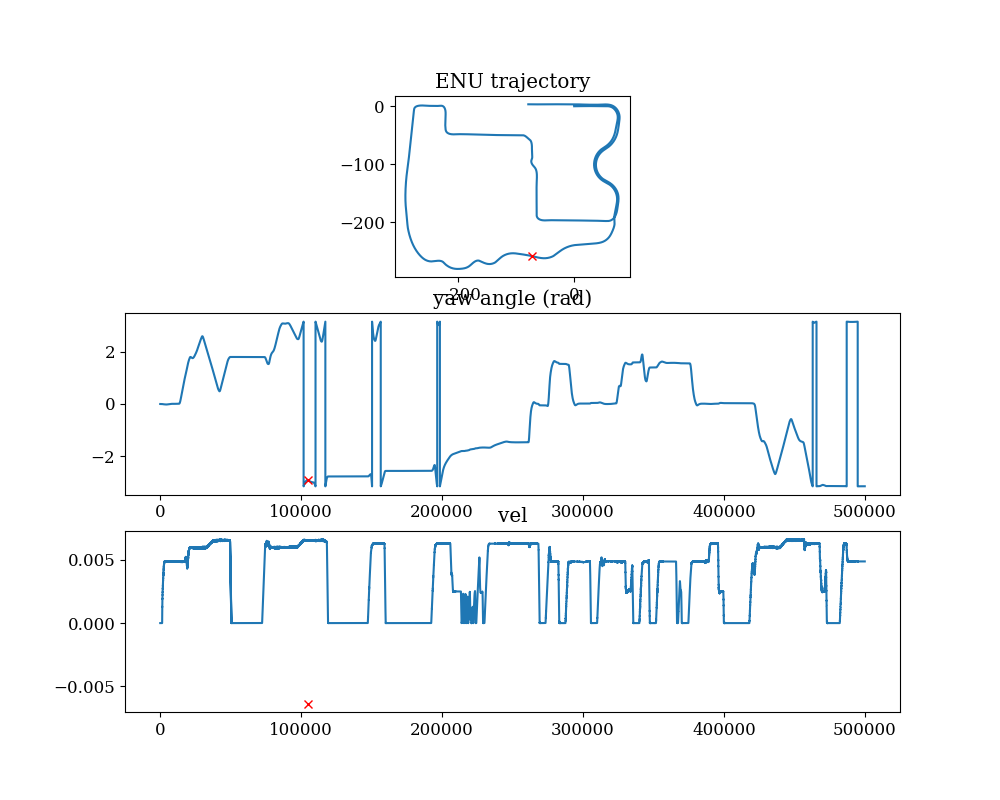

(3, 499999)


In [17]:
def R2Euler(mat):
    if len( np.shape(mat) ) == 2:
        mat = mat[None, :, :]
    R_sum = np.sqrt(( mat[:,0,0]**2 + mat[:,0,1]**2 + mat[:,1,2]**2 + mat[:,2,2]**2 ) / 2)
    phi = np.arctan2(-mat[:,1,2],mat[:,2,2])
    theta = np.arctan2(mat[:,0,2], R_sum)
    psi = np.arctan2(-mat[:,0,1], mat[:,0,0])
    angs = np.array([phi, theta, psi])
    return angs

#get ground truth transformation

town = 'Town07'
idx = 1050 #1050 for town1, 50 for town7


fpl = np.loadtxt("/home/derm/KITTICARLA/dataset/" + town + "/generated/full_poses_lidar.txt") #full poses lidar
print(np.shape(fpl))

#plot pose at arbitrary point in drive NEED TO MULTIPLY THIS BY 100??!

#create rotation vector
R = np.array([[fpl[:,0], fpl[:,1], fpl[:,2]],
              [fpl[:,4], fpl[:,5], fpl[:,6]],
              [fpl[:,8], fpl[:,9], fpl[:,10]]]).T
# R = np.transpose(R, (0,2,1))
# print(np.shape(R))
# print(R[-3])

angs = R2Euler(R) #convert to euler angles (for use with ICET)
# print(angs.T)

T = np.array([fpl[:,3], fpl[:,7], fpl[:,11]]).T #get translation vector
print(T[idx*100])

#plot results
fig, ax = plt.subplots(3,1)
ax[0].plot(T[:,0], T[:,1])
ax[0].plot(T[idx*100,0], T[idx*100,1], 'rx')
ax[0].set_aspect("equal")
ax[0].set_title("ENU trajectory")

ax[1].set_title("yaw angle (rad)")
ax[1].plot(angs[2,:])
ax[1].plot(idx*100, angs[2,idx*100], 'rx')

#TODO: get change in angles between subsequent transformations, fixangs greater than 2pi
vel = np.diff(T.T)
vf = np.sqrt(vel[0,:]**2 + vel[1,:]**2)
print(np.shape(vel))
ax[2].set_title("vel")
ax[2].plot(vf)
ax[2].plot(idx*100, vel[0,idx*100], 'rx')

#sanity check for consistant timesteps...
# dt = np.diff(fpl[:,12])
# bad = dt[abs(dt[:] - 0.001) > 0.00001]
# print(bad)

In [20]:
import trimesh

skip = 5
noise_scale = 0.02
plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True) #ax=7 gives rulers
disp = []

s1_fn = '/home/derm/KITTICARLA/dataset/' + town + '/generated/frames/frame_%04d.ply' %(idx)
s2_fn = '/home/derm/KITTICARLA/dataset/' + town + '/generated/frames/frame_%04d.ply' %(idx+skip)

dat1 = trimesh.load(s1_fn)
dat2 = trimesh.load(s2_fn)

c1 = dat1.vertices
# c1 += true_traj[(idx)*100]
c1 = c1.dot(R[(idx)*100])
# mesh = Mesh(dat1).c("gray").alpha(1) #draw ignored points on ground plane
# disp.append(mesh)

c2 = dat2.vertices
# c2 += true_traj[(idx+skip)*100]
c2 = c2.dot(R[(idx+skip)*100])
# c2 = c2 + (vel[:,(idx+skip)*100] + vel[:,(idx)*100])*50*(skip) #transform c2 to overlay with c1 #was this
# correction = np.sum(vel[:,((idx-1)*100):((idx-1+skip)*100)], axis = 1) #test1
# c2 = c2 + correction
# print(correction)

# c1 = c1[c1[:,2] > -1.5]
# c2 = c2[c2[:,2] > -1.5] #ground + sidewalk

#display overal trajectory via "poses_lidar.ply" ~~~~~~~~~~~~~~~~~~~~~~~~~~
fn = "/home/derm/KITTICARLA/dataset/" + town + "/generated/poses_lidar.ply"
datposes = trimesh.load(fn)
true_traj = datposes.vertices
# print(true_traj)
disp.append(Points(true_traj - [0, 0, 1.65], alpha = 0.3))

#true location (for viz)
c1 += true_traj[(idx)*100]
c2 += true_traj[(idx+skip)*100]
#center at 0 (for training data)
# c2 += true_traj[(idx+skip)*100] - true_traj[(idx)*100]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
c1 += noise_scale*np.random.randn(np.shape(c1)[0],3)
c2 += noise_scale*np.random.randn(np.shape(c2)[0],3)

disp.append(Points(c1, c = 'red', r = 2, alpha = 1.0))
disp.append(Points(c2, c = 'blue', r = 2, alpha = 1.0))

disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))
plt1.show(disp, "surface sampling test")
ViewInteractiveWidget(plt1.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


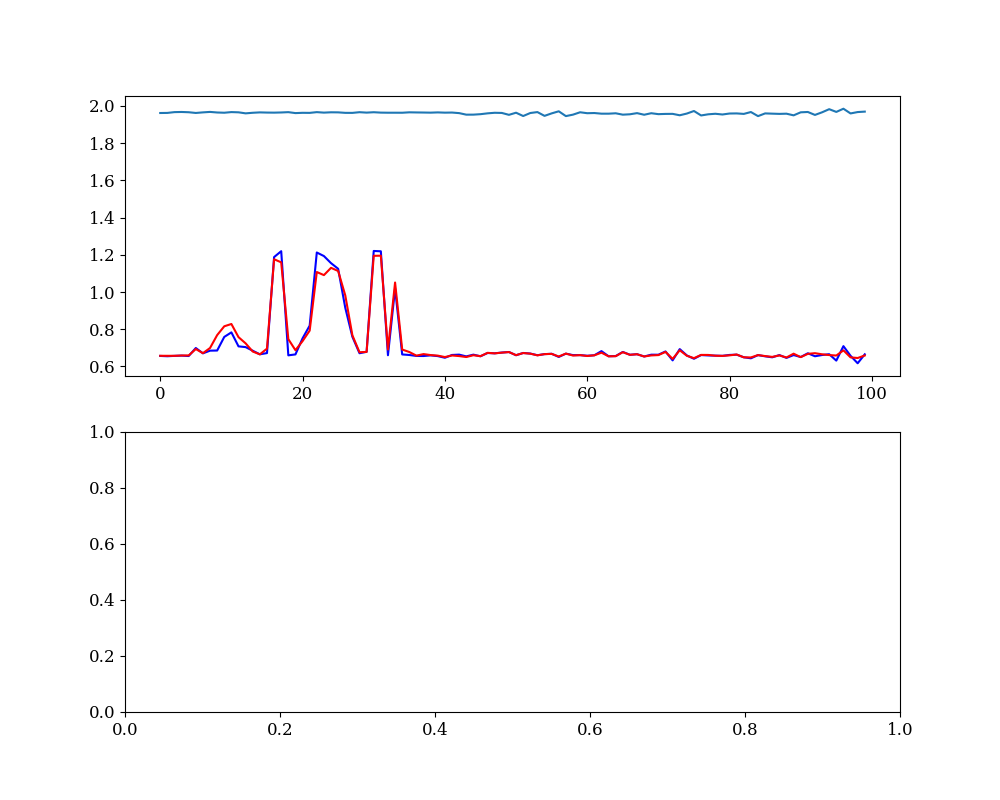

In [21]:
#Town7~~~~~~~~~~~~
ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KC_Town7_1050_CompactNet_5cmThresh.txt")
ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KC_Town7_1050_pred_stds_5cmThresh.txt")
BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KC_Town7_1050_noDNN.txt")
#~~~~~~~~~~~~~~~~

fig, ax = plt.subplots(2,1)

ax[0].plot(vf[1050*100:1150*100:100]*300)
ax[0].plot(ICET_estimates[:,0], 'b')
ax[0].plot(BC[:,0], 'r')

# KITTI Odometry (full) Datasets

In [22]:
def R2Euler(mat):
    """determines euler angles from euler rotation matrix"""

    if len( tf.shape(mat) ) == 2:
        mat = mat[None, :, :]

    R_sum = np.sqrt(( mat[:,0,0]**2 + mat[:,0,1]**2 + mat[:,1,2]**2 + mat[:,2,2]**2 ) / 2)

    phi = np.arctan2(-mat[:,1,2],mat[:,2,2])
    theta = np.arctan2(mat[:,0,2], R_sum)
    psi = np.arctan2(-mat[:,0,1], mat[:,0,0])

    angs = np.array([phi, theta, psi])
    return angs

<IPython.core.display.Javascript object>


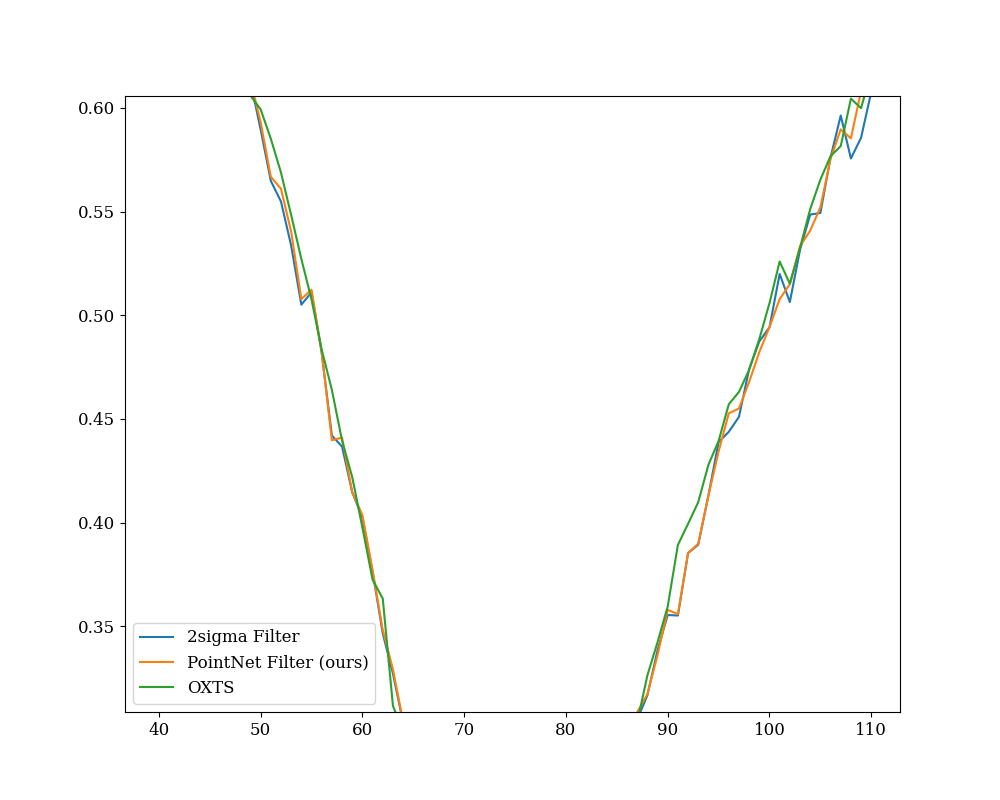

In [103]:
full_poses = np.loadtxt('/media/derm/06EF-127D1/KITTI/sequences/03/03.txt') #full transformation matrix
mat_full = np.reshape(full_poses, [-1,3,4])
Rmat = tf.convert_to_tensor(mat_full[:,:,:3]) #get rotation matrices
euls = R2Euler(Rmat)

endframe = 790

East = mat_full[:(endframe+1),2,3]
North = mat_full[:(endframe+1),0,3]
gt_fwd = np.sqrt(np.diff(East)**2 + np.diff(North)**2)

# noDNN = np.loadtxt('/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_03_noDNN.txt')[:endframe,:] #RMpt5
# noDNN = np.loadtxt('/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_03_RMpt1_v2.txt')[:endframe,:] #RMpt1
# noDNN = np.loadtxt('/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_03_RMpt1_v2.txt')[:endframe,:] #RMpt1
noDNN = np.loadtxt('/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_03_raw.txt')[:endframe,:] #raw


# rmOnly = np.loadtxt('/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_03_RMpt1.txt')[:endframe,:] #RMpt1

ours = np.loadtxt('/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_03_CompactNet.txt')[:endframe,:]
pred_stds = np.loadtxt('/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_03_pred_stds.txt')[:endframe,:]

# worst = rmOnly

# ours = ours*1.01 #debug
# noDNN = noDNN*1.01

#outlier rejection (FOR DEBUG ONLY!) ~~~~~~
rejectThresh = .3
diff_cheat_DNN = abs(ours[:,0] - gt_fwd)
bad_idx_DNN = np.where(diff_cheat_DNN > rejectThresh)
ours[bad_idx_DNN,0] = gt_fwd[bad_idx_DNN]
diff_cheat_noDNN = abs(noDNN[:,0] - gt_fwd)
bad_idx_noDNN = np.where(diff_cheat_noDNN > rejectThresh)
noDNN[bad_idx_noDNN,0] = gt_fwd[bad_idx_noDNN]
diff_cheat_rmOnly = abs(rmOnly[:,0] - gt_fwd)
bad_idx_worst = np.where(diff_cheat_rmOnly > rejectThresh)
rmOnly[bad_idx_worst,0] = gt_fwd[bad_idx_worst]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, ax = plt.subplots()
ax.plot(noDNN[:,0], label = "2sigma Filter")
# ax.plot(rmOnly[:,0], label = "RM only")
ax.plot(ours[:,0], label = "PointNet Filter (ours)")
ax.plot(gt_fwd, label = 'OXTS')
ax.legend(loc = 'best')

<IPython.core.display.Javascript object>


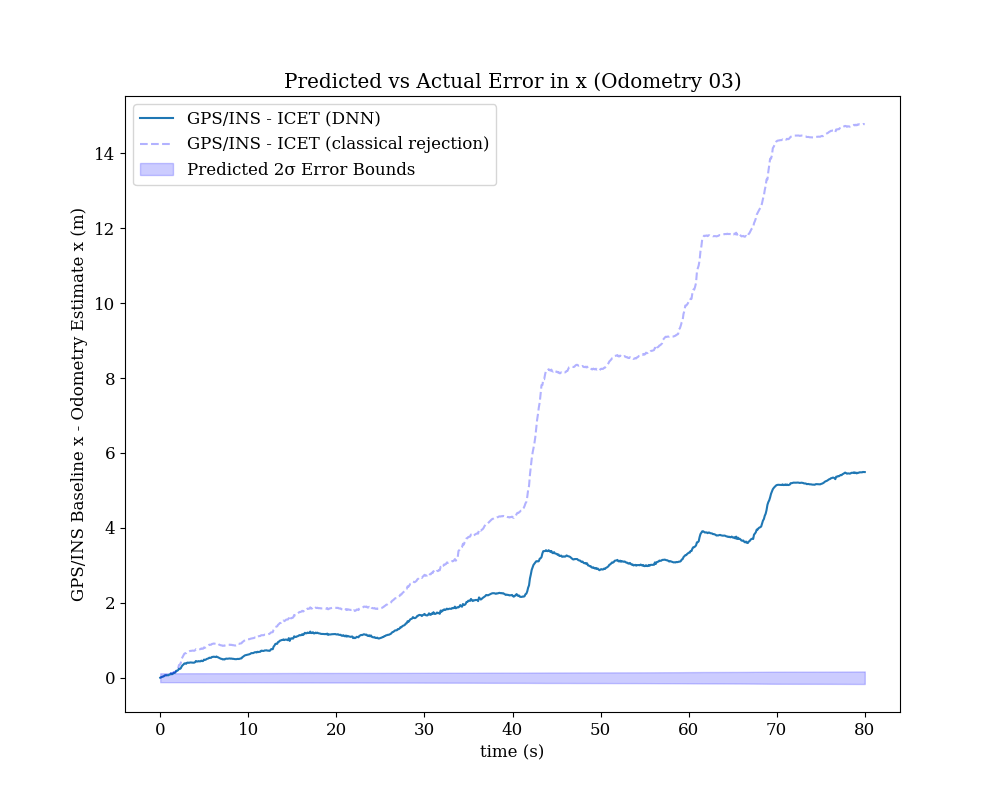

Text(0, 0.5, 'GPS/INS Baseline x - Odometry Estimate x (m)')

In [104]:
#plot error between ICET and absolute position
fig3, ax3 = plt.subplots(1,1)

c = 0 # x (forward movement)

diffx = gt_fwd - ours[:,c]
diffx_noDNN = gt_fwd - noDNN[:,c]
diffx_worst = gt_fwd - worst[:,c]

# print(abs(diffx))
# print("correlation coefficient \n", np.corrcoef(abs(diffx), ICET_pred_stds[:,0]))
    
cum_err = np.zeros(np.shape(pred_stds))
cum_diffx = np.zeros(np.shape(diffx))
cum_diffx_noDNN = np.zeros(np.shape(diffx_noDNN))
cum_diffx_worst = np.zeros(np.shape(diffx_worst))

for i in range(np.shape(pred_stds)[0]):
    cum_err[i,:] = np.sum(pred_stds[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
#     cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2 #test    
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 
    cum_diffx_noDNN[j] = np.sum(diffx_noDNN[:j]) 
    cum_diffx_worst[j] = np.sum(diffx_worst[:j]) 

# # #old (error for each individual timestep)------------------------
# ax3.plot(diffx, label = 'GPS/INS - NDT (with DNN)')
# ax3.plot(diffx_noDNN, 'b--', label = 'GPS/INS - NDT (no DNN)', alpha = 0.3)
# ax3.fill_between(np.linspace(0,800,np.shape(pred_stds)[0]), -2*pred_stds[:,c], 2*pred_stds[:,c], 
#                  color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
# #-------------------------------------------------------------------

# #new (accumulated differences in error)--------------------------
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
ax3.plot(np.linspace(0,80,np.shape(pred_stds)[0]), cum_diffx, label = 'GPS/INS - ICET (DNN)')
ax3.plot(np.linspace(0,80,np.shape(pred_stds)[0]), cum_diffx_noDNN, 'b--', alpha = 0.3, label = 'GPS/INS - ICET (classical rejection)')
# ax3.plot(np.linspace(0,80,np.shape(pred_stds)[0]), cum_diffx_worst, 'g', alpha = 0.3, label = 'GPS/INS - ICET (no rejection)')
ax3.fill_between(np.linspace(0,80,np.shape(pred_stds)[0]), -2*cum_err[:,c], 2*cum_err[:,c], 
                 color = (0,0,1,0.2), label = 'Predicted 2σ Error Bounds')
# # --------------------------------------------------------------------

ax3.legend(loc = 'best')
ax3.set_title("Predicted vs Actual Error in x (Odometry 03)")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("GPS/INS Baseline x - Odometry Estimate x (m)")

In [105]:
RMSE_DNN = np.sqrt(mean_squared_error(diffx, np.zeros(np.shape(diffx))))
print("RMSE_DNN: \n", RMSE_DNN)

RMSE_BC = np.sqrt(mean_squared_error(diffx_noDNN, np.zeros(np.shape(diffx))))
print("RMSE_BC: \n", RMSE_BC)

rel = (RMSE_BC - RMSE_DNN)/RMSE_BC
print(rel)

RMSE_DNN: 
 0.026025841815660512
RMSE_BC: 
 0.046971436516910506
0.44592195288107117


In [33]:
t = np.loadtxt('/media/derm/06EF-127D1/KITTI/sequences/03/times.txt')
print(np.mean(np.diff(t)))

0.103407725
